<a href="https://colab.research.google.com/github/Arup3201/Pneumonia-Classification-Tensorflow/blob/main/Pneumonia_classification_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import PIL
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arup7365","key":"3e6fc8bbfd2313c52a80876d1cbb40ca"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:26<00:00, 92.1MB/s]
100% 2.29G/2.29G [00:26<00:00, 94.2MB/s]


In [4]:
!unzip -q chest-xray-pneumonia.zip
!rm chest-xray-pneumonia.zip

In [5]:
data_dir = Path('./chest_xray')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [6]:
train_image_count = len(list(train_dir.glob("*/*.jpeg")))
val_image_count = len(list(val_dir.glob("*/*.jpeg")))
test_image_count = len(list(test_dir.glob("*/*.jpeg")))

In [7]:
print(f"Images in the training set: {train_image_count}")
print(f"Images in the validation set: {val_image_count}")
print(f"Images in the test set: {test_image_count}")

Images in the training set: 5216
Images in the validation set: 16
Images in the test set: 624


In [8]:
train_images = list(train_dir.glob("*/*.jpeg"))
val_images = list(val_dir.glob("*/*.jpeg"))
test_images = list(test_dir.glob("*/*.jpeg"))

In [9]:
normal_images = list(train_dir.glob("NORMAL/*.jpeg"))
pneumonia_images = list(train_dir.glob("PNEUMONIA/*.jpeg"))

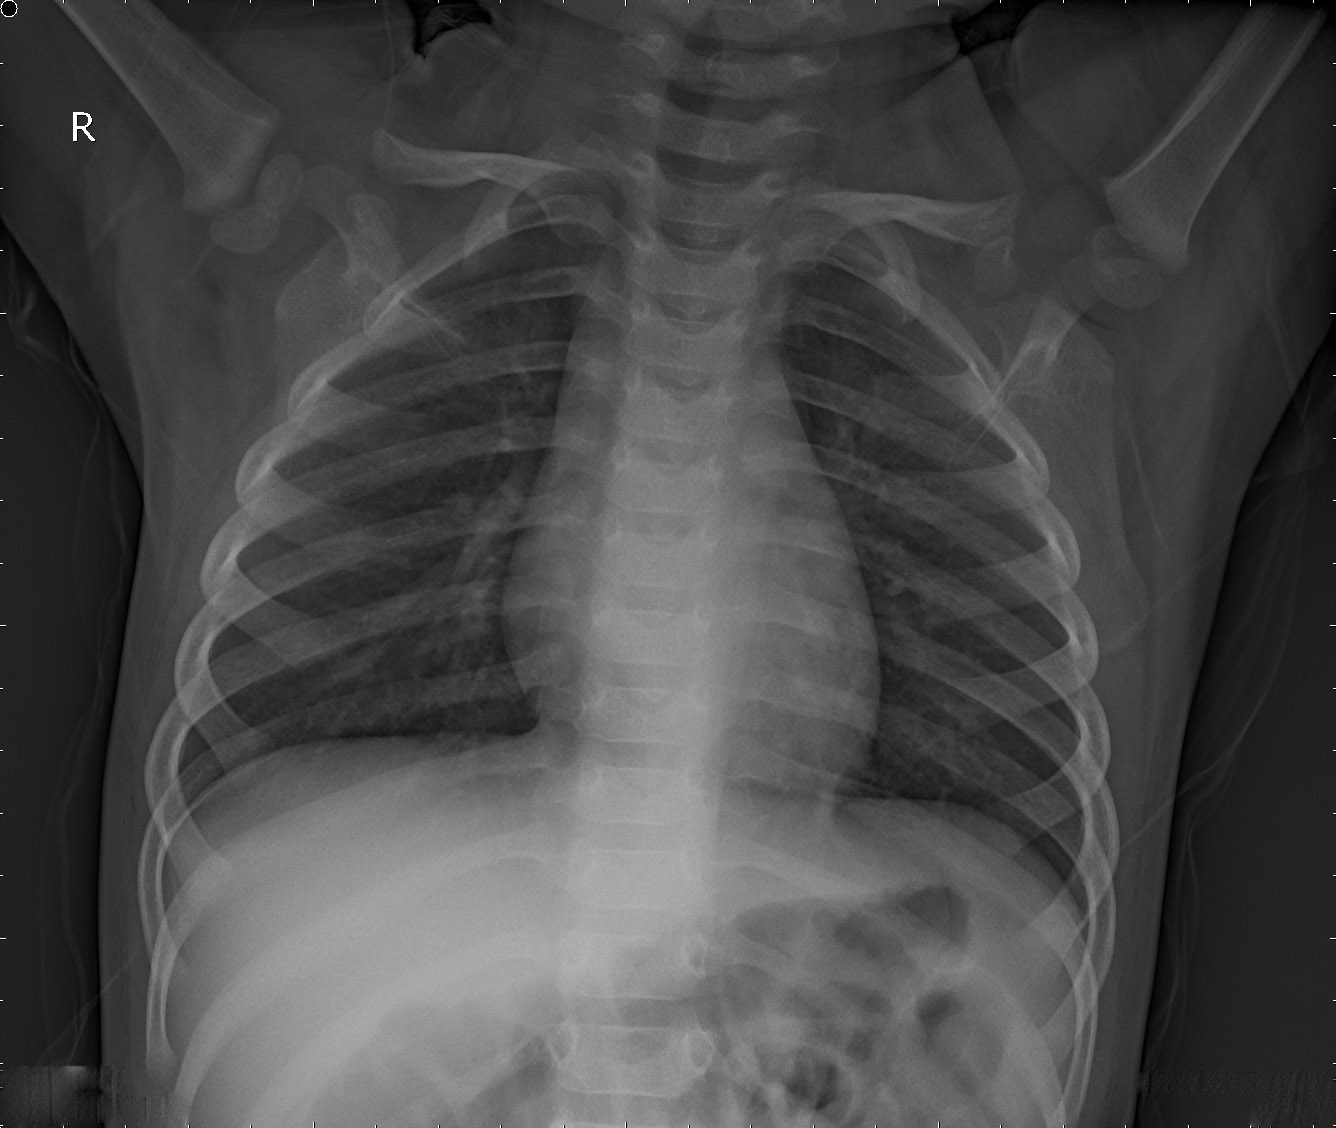

In [10]:
PIL.Image.open(normal_images[0])

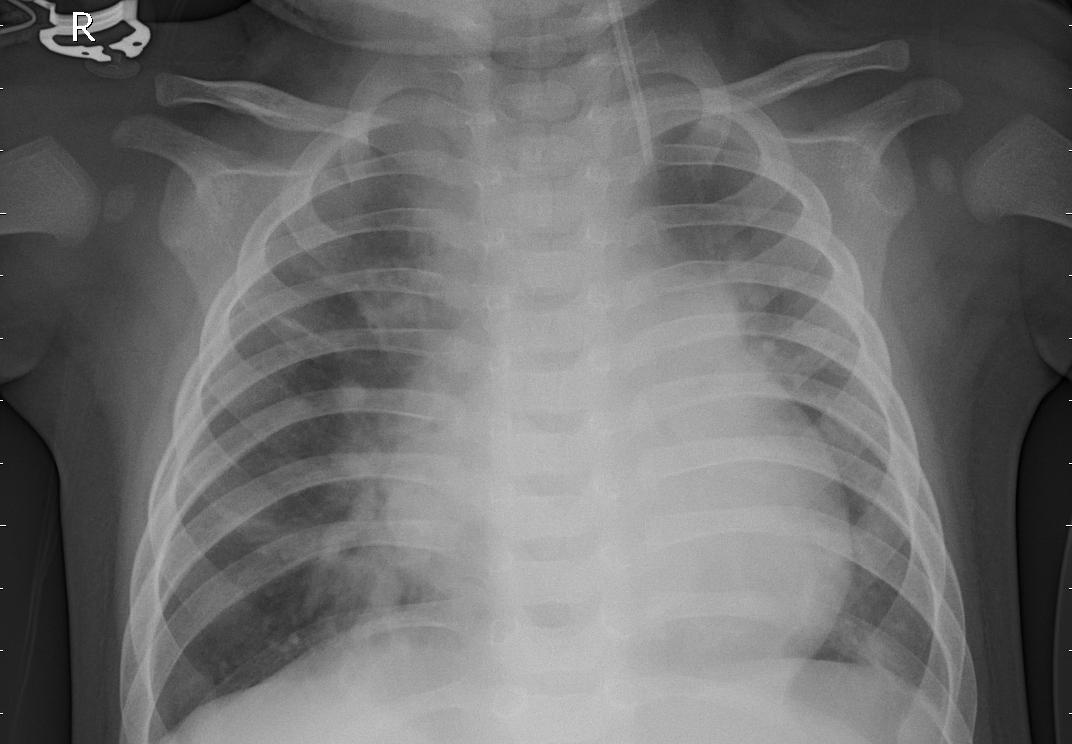

In [11]:
PIL.Image.open(pneumonia_images[0])

In [12]:
batch_size = 32
img_height = 180
img_width = 180

In [13]:
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123
)

val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [14]:
class_names = train_ds.class_names
print(f"Classes: {class_names}")

Classes: ['NORMAL', 'PNEUMONIA']


In [15]:
num_classes = len(class_names)

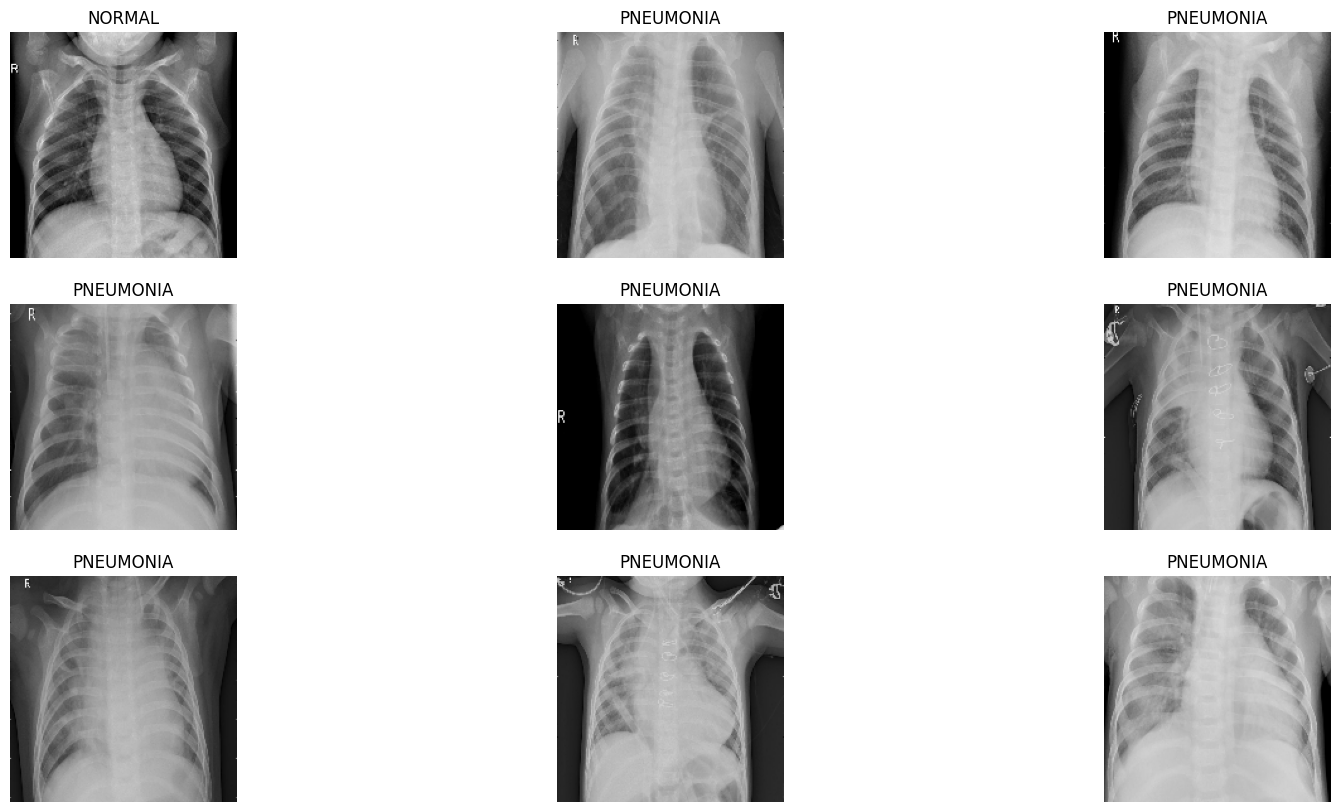

In [16]:
plt.figure(figsize=(20, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, label_batch in train_ds.take(1):
  print(f"Image batch shape: {image_batch.shape}")
  print(f"Labels batch shape: {label_batch.shape}")
  break

Image batch shape: (32, 180, 180, 3)
Labels batch shape: (32,)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [21]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
163/163 [==============================] - 46s 26ms/step - loss: 0.2555 - accuracy: 0.8873 - val_loss: 0.2498 - val_accuracy: 0.9375
Epoch 2/15
163/163 [==============================] - 3s 21ms/step - loss: 0.1042 - accuracy: 0.9638 - val_loss: 0.1718 - val_accuracy: 1.0000
Epoch 3/15
163/163 [==============================] - 4s 22ms/step - loss: 0.0722 - accuracy: 0.9730 - val_loss: 0.2326 - val_accuracy: 0.7500
Epoch 4/15
163/163 [==============================] - 3s 20ms/step - loss: 0.0594 - accuracy: 0.9780 - val_loss: 0.0987 - val_accuracy: 1.0000
Epoch 5/15
163/163 [==============================] - 3s 20ms/step - loss: 0.0486 - accuracy: 0.9816 - val_loss: 0.0673 - val_accuracy: 1.0000
Epoch 6/15
163/163 [==============================] - 3s 20ms/step - loss: 0.0373 - accuracy: 0.9854 - val_loss: 0.4386 - val_accuracy: 0.8750
Epoch 7/15
163/163 [==============================] - 3s 21ms/step - loss: 0.0218 - accuracy: 0.9904 - val_loss: 0.3324 - val_accuracy: 0.875

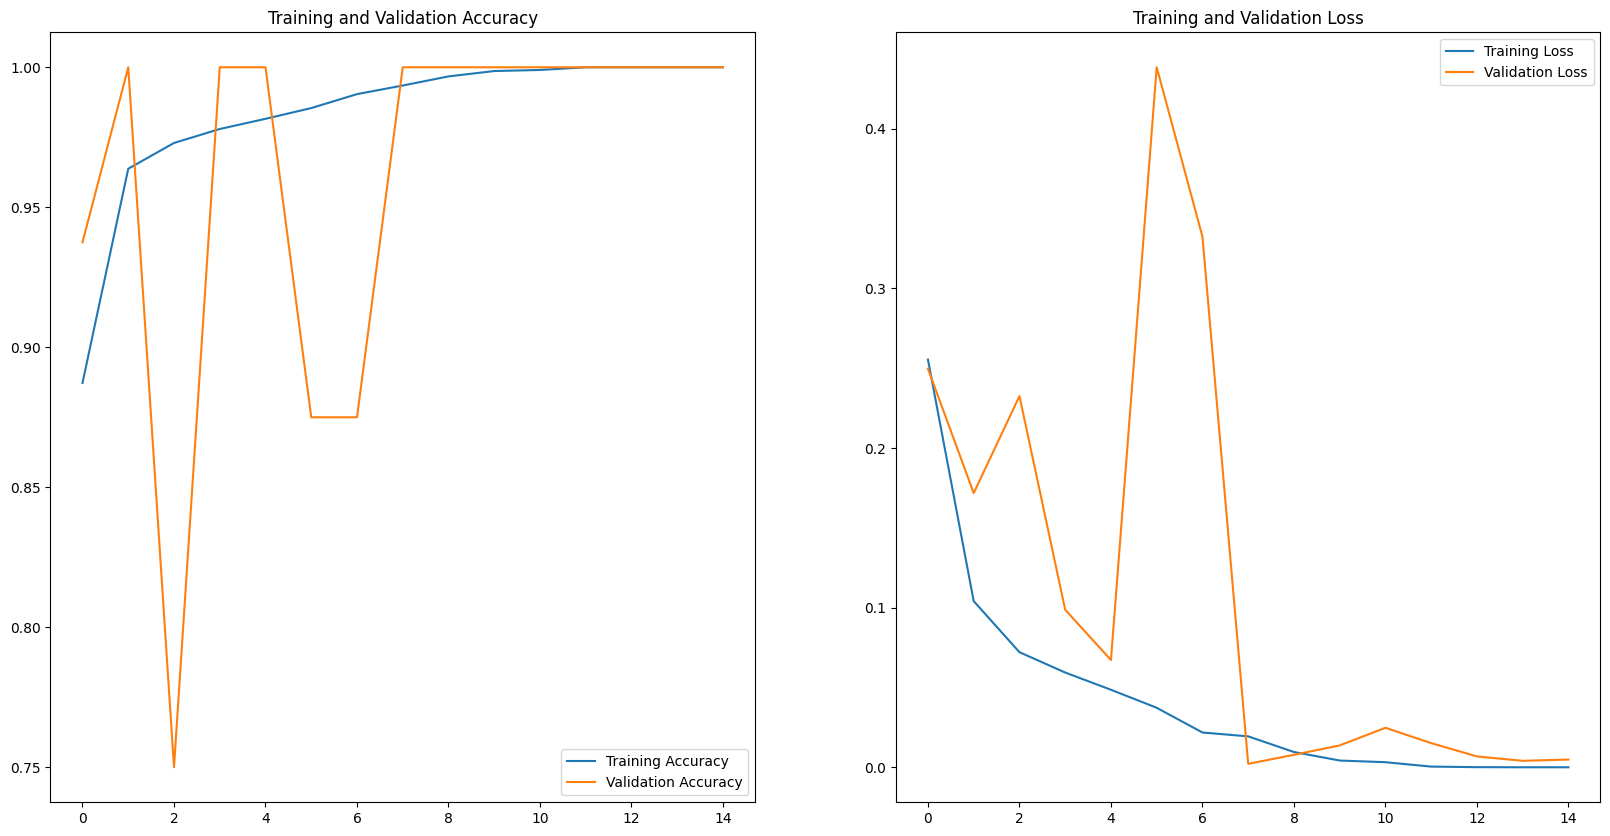

In [22]:
plt.figure(figsize=(20, 10))

epoch_range = range(epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
ax = plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, label="Training Accuracy")
plt.plot(epoch_range, val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend(loc="lower right")

loss = history.history['loss']
val_loss = history.history['val_loss']
ax = plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label="Training Loss")
plt.plot(epoch_range, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend(loc="upper right")

plt.show()